In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [10]:
inspector = inspect(engine)

In [11]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


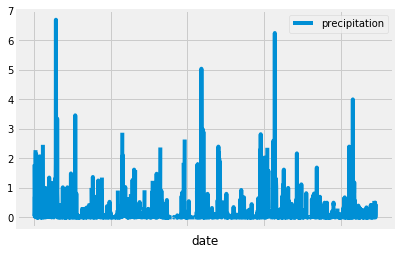

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
    
# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(func.max(Measurement.date)).all()
year_ago = dt.datetime.strptime(max_date[0][0], '%Y-%m-%d').date()-dt.timedelta(12*365/12)

# Perform a query to retrieve the data and precipitation scores
one_year_data = session.query(Measurement.date, Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= func.strftime("%Y-%m-%d",year_ago)).all()
# len(one_year_data)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(one_year_data, columns=['date', 'precipitation'])
df = df.set_index(df['date'])

# Sort the dataframe by date
df = df.sort_values(by=['date'], ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
# df.plot.bar()
# cur_axes = plt.gca()
# cur_axes.axes.get_xaxis().set_ticks([])

df.plot(x_compat=True)
plt.show()

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(func.count(Station.id.distinct())).all()

stations_count

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity_count = session.query(Measurement.station, func.count(Measurement.id).label('stat_count')).\
    group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()

station_activity_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

active_station_tobs = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs),\
                            func.avg(Measurement.tobs)).group_by(Measurement.station).\
                        filter(Measurement.station == station_activity_count[0][0]).all()

active_station_tobs


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

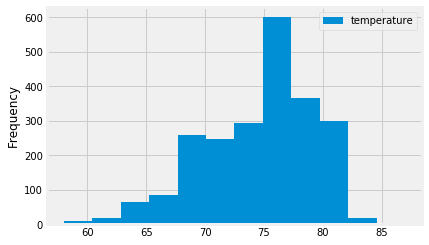

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_temp_count = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).filter(Measurement.tobs.isnot(None)).\
    order_by(func.count(Measurement.tobs).desc()).first()

# Calculate the date 1 year ago from the last data point in the database for the station with highest number of temperature observations.
station_max_date = session.query(func.max(Measurement.date)).filter(Measurement.station == station_temp_count[0]).all()
station_year_ago = dt.datetime.strptime(station_max_date[0][0], '%Y-%m-%d').date()-dt.timedelta(12*365/12)

# Perform a query to retrieve the data and temperature observations
station_one_year_data = session.query(Measurement.date, Measurement.tobs).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= func.strftime("%Y-%m-%d",station_year_ago)).\
    order_by(Measurement.date).all()
# len(station_one_year_data)

# Save the query results as a Pandas DataFrame and set the index to the date column
temp_df = pd.DataFrame(station_one_year_data, columns = ['date','temperature'])
temp_df.set_index(temp_df['date'], inplace=True)

# Plot the results
temp_df.plot.hist(bins=12)
plt.show()


In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.datetime.strptime('2018-01-01', '%Y-%m-%d').date()-dt.timedelta(12*365/12)
end_date = dt.datetime.strptime('2018-01-07', '%Y-%m-%d').date()-dt.timedelta(12*365/12)

temp_stats = calc_temps(start_date, end_date)

temp_stats

[(62.0, 68.36585365853658, 74.0)]

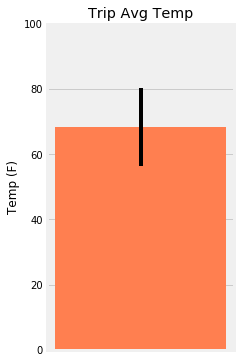

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize = (3, 6))

plt.bar(x=np.arange(1), height=temp_stats[0][1], yerr=temp_stats[0][2]-temp_stats[0][0], width=0.25, color='coral')
ind = []
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xticks(ind,'')
plt.yticks(np.arange(0, 101, 20))

plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_data = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude,\
                              Station.elevation, func.sum(Measurement.prcp)).\
            group_by(Measurement.station,  Station.name, Station.latitude, Station.longitude, Station.elevation).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
            order_by(func.sum(Measurement.prcp).desc()).all()

for s in rainfall_data:
    print(s)

('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.61)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.6)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.6)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.35)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.2)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)


## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.datetime.strptime('2018-01-01', '%Y-%m-%d').date()-dt.timedelta(12*365/12)
end_date = dt.datetime.strptime('2018-01-07', '%Y-%m-%d').date()-dt.timedelta(12*365/12)

# Use the start and end date to create a range of dates
trip_range = []
s_date = start_date
while s_date <= end_date:
    trip_range.append(s_date)
    s_date = s_date+dt.timedelta(days=1)

# Strip off the year and save a list of %m-%d strings
trip_dates = [r.strftime('%m-%d') for r in trip_range]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []

for d in trip_dates:
    normals.append(daily_normals(d)[0])


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ['tmin','tavg','tmax'])
normals_df['date']= pd.date_range(start=start_date, end=end_date, freq='D')
        
normals_df.head(20)

,tmin,tavg,tmax,date
0,62.0,69.153846,77.0,2017-01-01
1,60.0,69.396226,77.0,2017-01-02
2,62.0,68.909091,77.0,2017-01-03
3,58.0,70.000000,76.0,2017-01-04
4,56.0,67.964286,76.0,2017-01-05
5,61.0,68.964912,76.0,2017-01-06
6,57.0,68.543860,76.0,2017-01-07


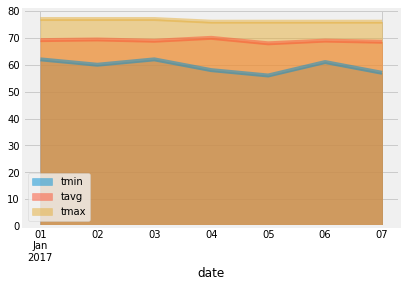

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(x='date',stacked=False)